In [1]:
!pip install matplotlib
!pip install nibabel
!pip install scikit-image
!pip install scikit-learn



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# DATASET
import nibabel as nib
import matplotlib.pyplot as plt

# Load the NIfTI file
data = nib.load("3702_left_knee.nii").get_fdata()

print(data.shape)



(512, 512, 216)


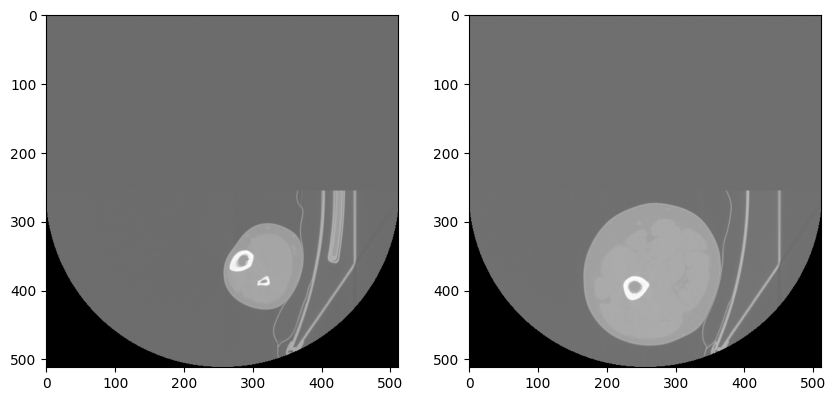

In [3]:
#VISUALIZATION OF DATASET

dt1 = data[:, :, 0]
dt2 = data[:, :, 215] 


plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(dt1, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(dt2, cmap = 'gray')
            
plt.show()

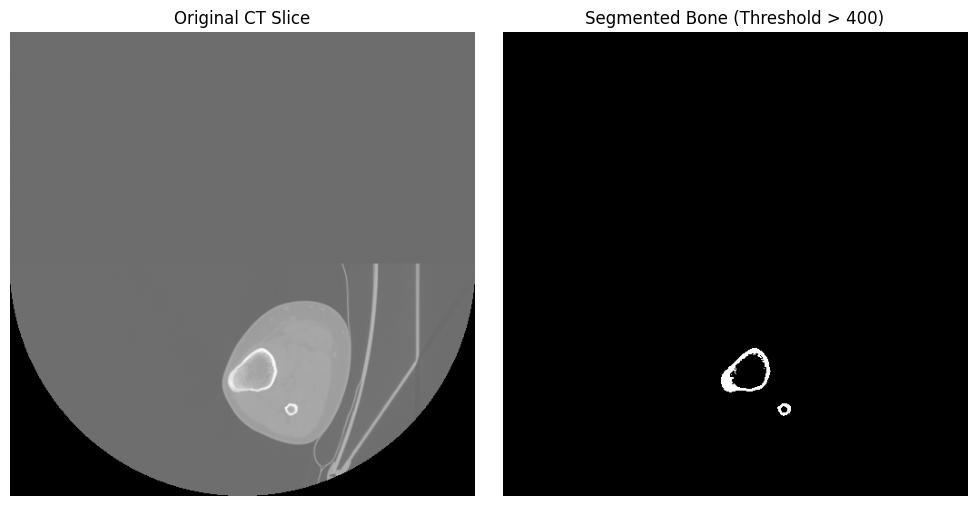

In [4]:
# BONE SEGMENTATION 

import numpy as np
import matplotlib.pyplot as plt

# Thresholding (for bone)
# Reference for selection of threshold : https://radiopaedia.org/articles/hounsfield-unit?lang=gb

# Parameters
segmentation_threshold = 500
index = 70


# Actual segmentation operation, which returns all values in Boolean
segmented_images = data > segmentation_threshold


# Sampling an image
original_image = data[:,:,index]
segmented_image = segmented_images[:,:,index]

# Display side-by-side
plt.figure(figsize=(10, 5))

# Original grayscale CT slice
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original CT Slice")
plt.axis('off')

# Segmented bone mask
plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Bone (Threshold > 400)")
plt.axis('off')

plt.tight_layout()
plt.show()




In [5]:
from scipy.ndimage import label

# bone_mask is your thresholded mask (e.g., data > 700)
labeled_arrays, num_features = label(segmented_images)

print(f"Found {num_features} components")




Found 400 components


6
The Image is of Lower Leg, and contains tibula and fibula
{1: 784, 2: 1, 3: 1, 4: 1, 5: 1, 6: 114}
Maximum Area Component :  1  with area of :  784
Hence, component 1 is Tibula
(512, 512)
(512, 512, 3)


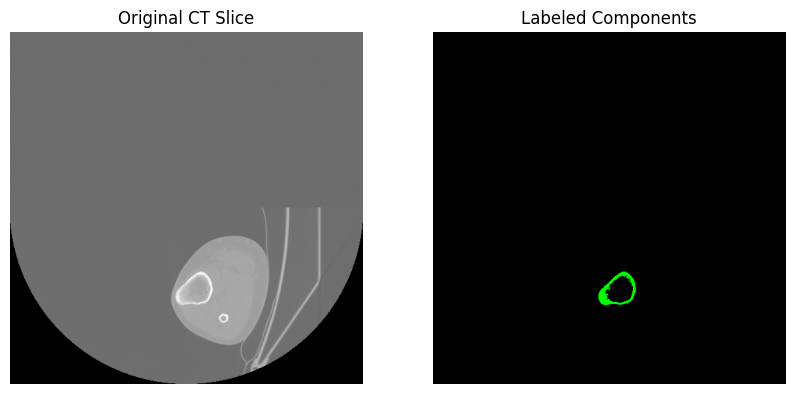

In [6]:
#TIBULA(GREEN) AND FEMUR SEGMENTATION(RED)

labeled_array, num_features = label(segmented_image)
binary_mask = labeled_array
print(num_features)


temparr1 = np.zeros((512,512), dtype = int)
temparr2 = np.zeros((512,512), dtype = int)


if num_features == 1:
    print('The Image is of Upper Leg and contains femur')
    area = {i : (labeled_array == i).sum() for i in range(1, num_features+1)}
    print(area)

    plt.figure(figsize=(10, 5))


    labeled_array = np.stack((labeled_array, temparr1, temparr2), axis = 2)
    labeled_array = labeled_array * 255

    
    plt.subplot(1, 2, 1)
    plt.imshow(data[:, :, index], cmap='gray')
    plt.title("Original CT Slice")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled_array, cmap='gray')  # Use colorful colormap
    plt.title("Labeled Components")
    plt.axis('off')
    
    plt.show()

else: 
    print('The Image is of Lower Leg, and contains tibula and fibula')
    area = {i : int((labeled_array == i).sum()) for i in range(1, num_features+1)}
    # checking area inorder to find tibula
    print(area)
    maximum_area = 0
    maximum_area_component = None
    for key, value in area.items():
        if value>maximum_area:
            maximum_area = value
            maximum_area_component = key
    print('Maximum Area Component : ', maximum_area_component,' with area of : ', maximum_area)
    print('Hence, component', maximum_area_component,'is Tibula')

    #Hiding fibula
    labeled_array[labeled_array != maximum_area_component] = 0

    print(labeled_array.shape)
    plt.figure(figsize=(10, 5))

    
    labeled_array = np.stack((temparr1, labeled_array, temparr2), axis = 2)
    labeled_array = labeled_array * 255
    print(labeled_array.shape)
    plt.subplot(1, 2, 1)
    plt.imshow(data[:, :, index], cmap='gray')
    plt.title("Original CT Slice")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled_array)  # Use colorful colormap
    plt.title("Labeled Components")
    plt.axis('off')
    
    plt.show()




In [7]:
area = [(labeled_array == i).sum() for i in range(1, num_features+1)]
# val = True
# print(int(val))
area

[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]

In [8]:
#EXPANSION OF THE COUNTOUR OF MASK

import numpy as np
from skimage.morphology import binary_dilation, disk, ellipse
from skimage import measure

def expand_mask_by_mm(mask, spacing, expansion_mm=2.0):
    # Calculate number of pixels to match expansion_mm
    pixels_y = int(round(expansion_mm / spacing[0]))
    pixels_x = int(round(expansion_mm / spacing[1]))

    # Create an elliptical structuring element to match anisotropic spacing
    selem = ellipse(pixels_y, pixels_x)
    
    # Expand the mask
    expanded_mask = binary_dilation(mask, selem)
    return expanded_mask



(512, 512)


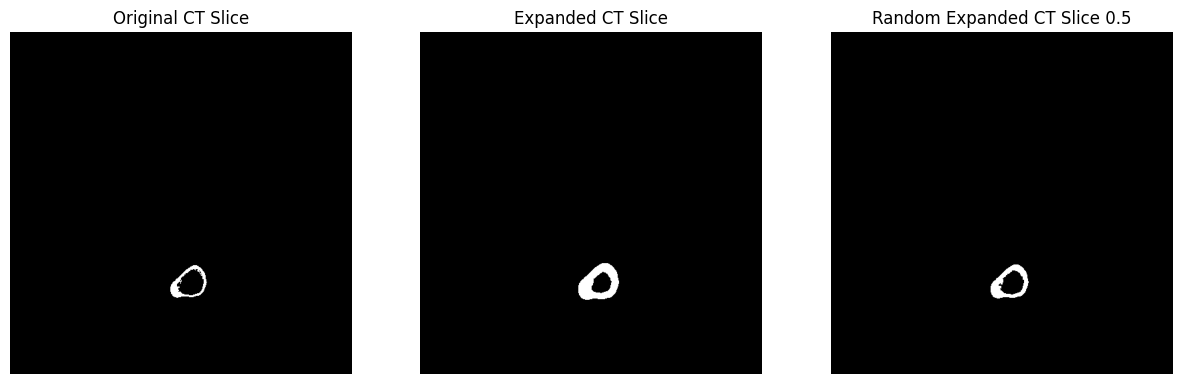

In [9]:
# Example binary mask and spacing (e.g., 0.5 mm/pixel)
# binary_mask = your binary mask
# spacing = (row_spacing_mm, col_spacing_mm), e.g. (0.7, 0.7)
# expansion_mm = 2.0
# random_level = 0.4 (40% of the way from original to full expansion)


spacing = (0.5, 0.5)  # (x, y) in mm/pixel



expanded = expand_mask_by_mm(binary_mask, spacing=(0.7, 0.7), expansion_mm=2.0)

ratio_of_expansion = 0.5

randomized = expand_mask_by_mm(binary_mask, spacing=(0.7, 0.7), expansion_mm=2.0 * ratio_of_expansion)
print(expanded.shape)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(binary_mask, cmap='gray')
plt.title("Original CT Slice")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(expanded, cmap='gray')  # Use colorful colormap
plt.title("Expanded CT Slice")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(randomized, cmap='gray')  # Use colorful colormap
plt.title(f"Random Expanded CT Slice {ratio_of_expansion}")
plt.axis('off')

plt.show()

(512, 512, 216)
0.5
(512, 512, 216) (512, 512, 216)


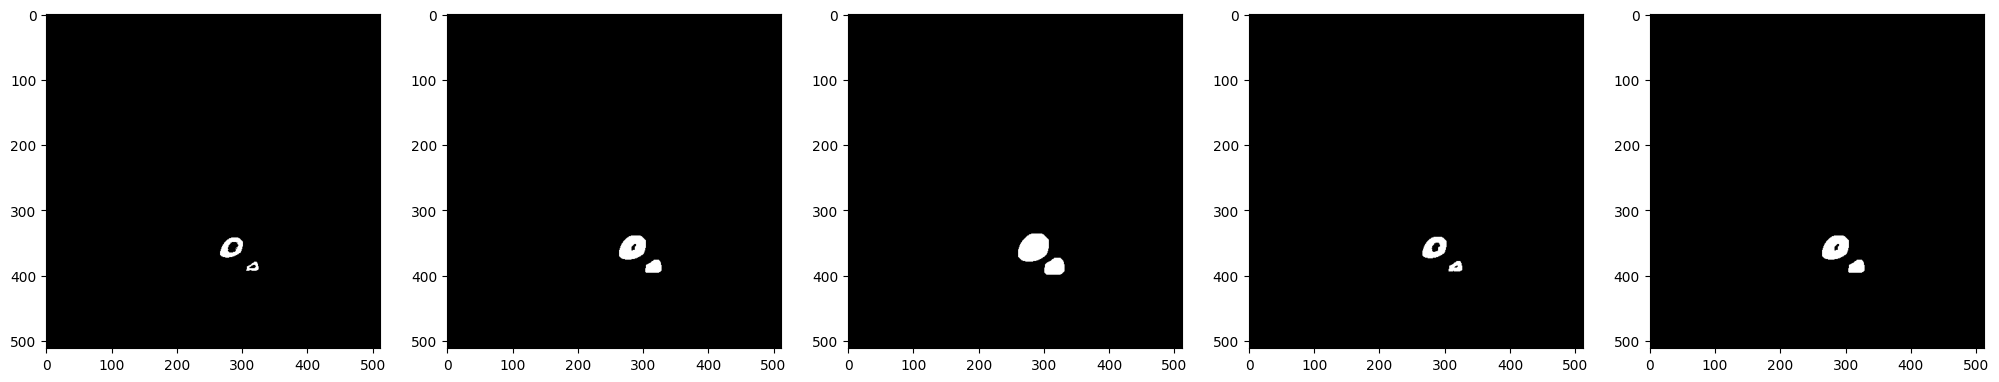

In [10]:
mask_2_list = []
mask_4_list = []
random_1_list = []
random_2_list = []



original_masks = data > segmentation_threshold


print(original_masks.shape)
#EXPANSION OF THE COUNTOUR OF MASK

print(ratio_of_expansion)

mask_2_list = [expand_mask_by_mm(original_masks[:,:,idx], spacing=(0.7, 0.7), expansion_mm=2.0) for idx in range(0, original_masks.shape[2])]
mask_4_list = [expand_mask_by_mm(original_masks[:,:,idx], spacing=(0.7, 0.7), expansion_mm=4.0) for idx in range(0, original_masks.shape[2])]
random_1_list = [expand_mask_by_mm(original_masks[:,:,idx], spacing=(0.7, 0.7), expansion_mm=2.0 * ratio_of_expansion) for idx in range(0, original_masks.shape[2])]
random_2_list = [expand_mask_by_mm(original_masks[:,:,idx], spacing=(0.7, 0.7), expansion_mm=4.0 * ratio_of_expansion) for idx in range(0, original_masks.shape[2])]


mask_2 = np.stack(mask_2_list, axis = 2)
mask_4 = np.stack(mask_4_list, axis = 2)
random_1 = np.stack(random_1_list, axis = 2)
random_2 = np.stack(random_2_list, axis = 2)

print(mask_2.shape, mask_4.shape)

idx_to_display = 0

plt.figure(figsize = (25,5))

plt.subplot(1, 5, 1)
plt.imshow(original_masks[:,:,idx_to_display], cmap='gray')

plt.subplot(1, 5, 2)
plt.imshow(mask_2[:,:,idx_to_display], cmap='gray')

plt.subplot(1, 5, 3)
plt.imshow(mask_4[:,:,idx_to_display], cmap='gray')

plt.subplot(1, 5, 4)
plt.imshow(random_1[:,:,idx_to_display], cmap='gray')

plt.subplot(1, 5, 5)
plt.imshow(random_2[:,:,idx_to_display], cmap='gray')

plt.show()

In [11]:
# Print shapes for confirmation
print("Original Mask Shape:", original_masks.shape)
print("2mm Expanded Mask Shape:", mask_2.shape)
print("4mm Expanded Mask Shape:", mask_4.shape)
print("Randomized Mask 1 Shape:", random_1.shape)
print("Randomized Mask 2 Shape:", random_2.shape)

# Load the affine from your original NIfTI file
# Replace 'original_mask_file.nii.gz' with the correct file
original_nifti = nib.load('3702_left_knee.nii')
affine = original_nifti.affine

# Create a dictionary of filenames and arrays
masks = {
    'original_mask.nii.gz': original_masks,
    'expanded_2mm.nii.gz': mask_2,
    'expanded_4mm.nii.gz': mask_4,
    'randomized_1.nii.gz': random_1,
    'randomized_2.nii.gz': random_2,
}

# Save each mask
for filename, array in masks.items():
    nifti_img = nib.Nifti1Image(array.astype(np.uint8), affine)
    nib.save(nifti_img, filename)
    print(f"Saved {filename}")

Original Mask Shape: (512, 512, 216)
2mm Expanded Mask Shape: (512, 512, 216)
4mm Expanded Mask Shape: (512, 512, 216)
Randomized Mask 1 Shape: (512, 512, 216)
Randomized Mask 2 Shape: (512, 512, 216)
Saved original_mask.nii.gz
Saved expanded_2mm.nii.gz
Saved expanded_4mm.nii.gz
Saved randomized_1.nii.gz
Saved randomized_2.nii.gz


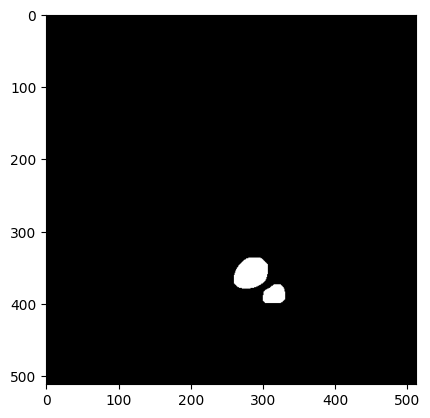

In [12]:
plt.imshow(mask_4[:,:,0],cmap='gray')
plt.show()


3
Tibia found...
The Image is of Lower Leg, and contains tibula and fibula
{1: 717, 2: 1, 3: 121}
Maximum Area Component :  1  with area of :  717
Hence, component 1 is Tibula
[145.  144.  143.  142.  141.  140.  139.5 139.  138.  137.5 137.  136.
 135.  134.5 134.  133.  132.  131.5 131.  130.  129.5 129.  128.5 128.
 127.  126.5 126.  125.5 125.5 125.  124.5 124.  123.5 123.5 123.  122.5
 122.5 122.5 122.  121.5 121.5 121.5 121.  120.5 120.5 120.5 120.5 120.5
 120.5 120.5 120.5 120.5 120.5 120.5 120.5 120.5 120.5 120.5 120.5 120.5
 120.5 120.5 120.5 120.5 120.5 120.5 120.5 120.5 121.  121.5 121.5 122.
 122.5 123.  123.5 124.  125.  126.  126.5 127.  128.  129.  130.  131.
 132.  133.  134.  135.  135.5 136.  137.  138.  138.5 139.  139.5 140.
 141.  141.5 142.  142.5 143.  143.5 144.  144.5 145.  145.5 146.  146.5
 147.  147.5 148.  148.5 149.  149.5 150.  150.5 151.  151.5 152.  152.5
 153.  153.5 154.  154.5 155.  155.5 156.  156.5 157.  157.5 157.5 158.
 158.5 159.  159.5 159.5 16

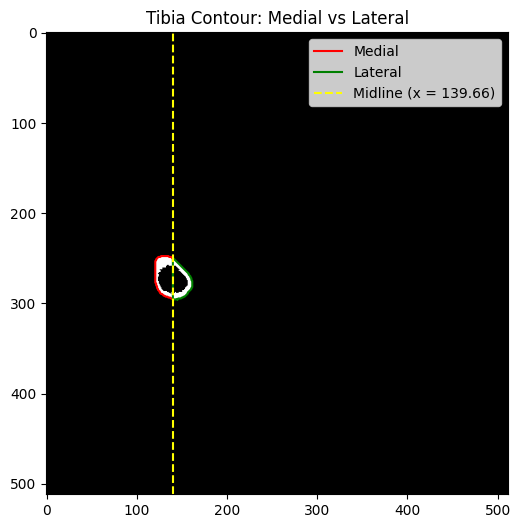

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
from skimage import measure



def find_largest_contour(mask_slice):
    """
    Finds the largest contour in a binary mask slice.
    Returns the contour as an array of (row, col) coordinates.
    """
    contours = measure.find_contours(mask_slice, level=0.5)
    
    if not contours:
        raise ValueError("No contours found in the slice.")
    
    # Select the largest contour by length
    largest_contour = max(contours, key=len)
    return np.array(largest_contour)


    
labeled_array, num_features = label(original_masks[:,:,60])
labeled_array = np.rot90(labeled_array, k=-1)

print(num_features)




    
if(num_features==1):
    print('Tibia not found...')
else:
    
    print('Tibia found...')
    print('The Image is of Lower Leg, and contains tibula and fibula')
    area = {i : int((labeled_array == i).sum()) for i in range(1, num_features+1)}
    # checking area inorder to find tibula
    print(area)
    maximum_area = 0
    maximum_area_component = None
    for key, value in area.items():
        if value>maximum_area:
            maximum_area = value
            maximum_area_component = key
    print('Maximum Area Component : ', maximum_area_component,' with area of : ', maximum_area)
    print('Hence, component', maximum_area_component,'is Tibula')
    
    #Hiding fibula
    labeled_array[labeled_array != maximum_area_component] = 0
    
    # Example usage
    mask_slice =labeled_array # Replace with your slice index
    contour = find_largest_contour(mask_slice)

    print(contour[:,1])
    mid_x = np.mean(contour[:, 1])
    print(mid_x)

    


    # Separate the contour into medial and lateral using mid_x
    medial_contour = contour[contour[:, 1] < mid_x]  # Left of midline
    lateral_contour = contour[contour[:, 1] >= mid_x]  # Right of midline

    print('Number of points in medial contour : ', len(medial_contour))
    print('Number of points in lateral contour : ', len(lateral_contour))

    max_y = 0
    
    for idx in range(0, len(medial_contour)):
        
    
    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(mask_slice, cmap='gray')
    
    # Plot medial (left) contour in red
    plt.plot(medial_contour[:, 1], medial_contour[:, 0], 'r', linewidth=1.5, label='Medial')
    
    # Plot lateral (right) contour in green
    plt.plot(lateral_contour[:, 1], lateral_contour[:, 0], 'g', linewidth=1.5, label='Lateral')
    
    # Vertical midline
    plt.axvline(x=mid_x, color='yellow', linestyle='--', label='Midline (x = {:.2f})'.format(mid_x))
    
    plt.legend()
    plt.title("Tibia Contour: Medial vs Lateral")
    plt.show()

